# OrgaTuring: AI Deciphers Organoids towards Futurizing Healthcare 

- CNN with Interpretability Pipeline to localize, quantize, and classify Organoid Inflamed and Non-Inflamed images

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:XLA_CPU:0 || Unnamed device || XLA_CPU || 16.0 GiB
 /device:XLA_GPU:0 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:1 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:2 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:XLA_GPU:3 || Unnamed device || XLA_GPU || 16.0 GiB
 /device:GPU:0 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:1 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:2 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB
 /device:GPU:3 ||  GeForce GTX 1080 Ti || GPU || 10.1 GiB


2022-09-24 13:23:37.596626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-24 13:23:37.597803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-24 13:23:37.598932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-24 13:23:37.600011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 3 with properties: 
pciBusID: 0000:82:00.0 n

In [4]:
#import packages
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
import splitfolders
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
import sklearn

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')


In [5]:
IMG_SIZE = 150
SEED = 42
GPUS = ["GPU:0", "GPU:1", "GPU:2","GPU:3"]

In [6]:
strategy = tf.distribute.MirroredStrategy(GPUS)
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


- Splitting the Dataset into train, test, and valid

In [7]:
# # Creating Train, Test, and Valid Dataset
# input_folder = "../../../aman/Updated_Dataset_2D/Sorted/"


In [8]:
# # Split with a ratio.

# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# # Train, val, test
# splitfolders.ratio(input_folder, output="./dataset/", 
#                    seed=42, ratio=(.7, .2, .1), 
#                    group_prefix=None) # default values

In [8]:
train_dir = os.path.join("./dataset/new_aug_dataset/train/")
valid_dir = os.path.join('./dataset/new_aug_dataset/val/')
test_dir = os.path.join('./dataset/new_aug_dataset/test/')

train_i_dir = os.path.join('./dataset/new_aug_dataset/train/Inflamed/')
train_ni_dir = os.path.join('./dataset/new_aug_dataset/train/NonInflamed/')

valid_i_dir = os.path.join('./dataset/new_aug_dataset/val/Inflamed/')
valid_ni_dir = os.path.join('./dataset/new_aug_dataset/val/NonInflamed')

test_i_dir = os.path.join('./dataset/new_aug_dataset/test/Inflamed/')
test_ni_dir = os.path.join('./dataset/new_aug_dataset/test/NonInflamed')

In [9]:
train_i_names = os.listdir(train_i_dir)
print(train_i_names [:10])

train_ni_names  = os.listdir(train_ni_dir)
print(train_ni_names [:10])

valid_i_names = os.listdir(valid_i_dir)
print(valid_i_names[:10])

valid_ni_names = os.listdir(valid_ni_dir)
print(valid_ni_names[:10])

test_i_names = os.listdir(test_i_dir)
print(test_i_names[:10])

test_ni_names = os.listdir(test_ni_dir)
print(test_ni_names[:10])

['CD11 IL-I-QS_2496 20x 190603_0_8109.tif', 'CD11-Il-I_QS_2470_0_8255.tif', 'CD62-I-I P3 200311 4X_0_6247.tif', 'CD13-Il-I_QS_2479_0_7970.tif', 'CD41-I-I p3 10x 9-19-19_0_3677.tif', 'CD11 IL-I-QS_2501 40x 190603_0_3807.tif', 'CD63-I-I P4 200325 4X_0_2796.tif', 'CD13-Il-I_QS_2477_0_1462.tif', 'CD42-I-I P0 190905 4x _0_1927.tif', 'CD11 ILEUM I _0_9593.tif']
['CD11-LC-NI P12 190905 4x.tif', 'CD28-R-NI P0 190701 10x_0_5876.tif', 'CD47-I-NI P5 191115 4X_0_7696.tif', 'CD28-R-NI P2 190707 10X_0_7199.tif', 'CD47-LC-NI P3 191023 10X_0_7837.tif', 'CD24-I-NI P1 190620 4X.tif', 'CD50-I-NI P3 191212 4X_0_862.tif', 'CD20-I-NI P7 190729 4x_0_8158.tif', 'CD60-LC p2 5x 012720_0_9664.tif', 'CD30-I-NI P3 190805 10X_0_8651.tif']
['CD11 IL-I-QS_2497 20x 190603_0_3336.tif', 'CD11 IL-I-QS_2497 20x 190603_0_9838.tif', 'CD63-I-I P3 200318 4X_0_2713.tif', 'CD11 IL-I-QS_2500 40x 190603_0_7359.tif', 'CD11 IL-I-QS_2497 20x 190603_0_3398.tif', 'CD62-I-I P1 202026 10X_0_6212.tif', 'CD42-I-I P2 190920 4X_0_3345.tif',

In [10]:
print('total training i images:', len(os.listdir(train_i_dir)))
print('total training ni images:', len(os.listdir(train_ni_dir)))
print('total validation i images:', len(os.listdir(valid_i_dir)))
print('total validation ni images:', len(os.listdir(valid_ni_dir)))
print('total testing i images:', len(os.listdir(test_i_dir)))
print('total testing ni images:', len(os.listdir(test_ni_dir)))

num_train_i =  len(os.listdir(train_i_dir))
num_train_ni =  len(os.listdir(train_ni_dir))
num_val_i =  len(os.listdir(valid_i_dir))
num_val_ni =  len(os.listdir(valid_ni_dir))
num_test_i =  len(os.listdir(test_i_dir))
num_test_ni =  len(os.listdir(test_ni_dir))

total_train =num_train_i  + num_train_ni
total_val = num_val_i  + num_val_ni
total_test = num_test_i   + num_test_ni 

print("-----------------------------------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total testing images:", total_test)

total training i images: 1493
total training ni images: 1505
total validation i images: 420
total validation ni images: 422
total testing i images: 227
total testing ni images: 228
-----------------------------------------------------
Total training images: 2998
Total validation images: 842
Total testing images: 455


In [11]:
train_i = glob.glob(train_i_dir+"/*.*")
train_ni = glob.glob(train_ni_dir+"/*.*")
# train_i_names

In [12]:
valid_i = glob.glob(valid_i_dir+"/*.*")
valid_ni = glob.glob(valid_ni_dir+"/*.*")
# train_i_names

In [13]:
test_i = glob.glob(test_i_dir+"/*.*")
test_ni = glob.glob(test_ni_dir+"/*.*")
# train_i_names

In [14]:
train_list = [x for x in train_i]
train_list.extend([x for x in train_ni])

df_train = pd.DataFrame(np.concatenate([['Inflamed']*len(train_i) , ['NonInflamed']*len(train_ni)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

In [15]:
valid_list = [x for x in valid_i]
valid_list.extend([x for x in valid_ni])

df_valid = pd.DataFrame(np.concatenate([['Inflamed']*len(valid_i) , ['NonInflamed']*len(valid_ni)]), columns = ['class'])
df_valid['image'] = [x for x in valid_list]

In [16]:
test_list = [x for x in test_i]
test_list.extend([x for x in test_ni])

df_test = pd.DataFrame(np.concatenate([['Inflamed']*len(test_i) , ['NonInflamed']*len(test_ni)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [17]:
df_train

,class,image
0,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11 IL-I-QS_2496 20x 190603_0_8109.tif
1,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_8255.tif
2,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD62-I-I P3 200311 4X_0_6247.tif
3,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD13-Il-I_QS_2479_0_7970.tif
4,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD41-I-I p3 10x 9-19-19_0_3677.tif
...,...,...
2993,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD20-LC-NI P7 190801 4X_0_9237.tif
2994,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD63-LC-NI P5 200323 10X_0_4659.tif
2995,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R p3 9.14.19 10x_0_4453.tif
2996,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R-NI P6 191003 10X 3_0_5781.tif


In [18]:
class_i = df_train[df_train['class'] == 'Inflamed']
class_ni = df_train[df_train['class'] == 'NonInflamed']


In [19]:
class_i

,class,image
0,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11 IL-I-QS_2496 20x 190603_0_8109.tif
1,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_8255.tif
2,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD62-I-I P3 200311 4X_0_6247.tif
3,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD13-Il-I_QS_2479_0_7970.tif
4,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD41-I-I p3 10x 9-19-19_0_3677.tif
...,...,...
1488,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_9548.tif
1489,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD 11 ILEUM_0_6516.tif
1490,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD42-I-I P2 190920 10X_0_9741.tif
1491,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD 11 ILEUM_0_2267.tif


In [20]:
class_ni

,class,image
1493,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD11-LC-NI P12 190905 4x.tif
1494,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD28-R-NI P0 190701 10x_0_5876.tif
1495,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD47-I-NI P5 191115 4X_0_7696.tif
1496,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD28-R-NI P2 190707 10X_0_7199.tif
1497,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD47-LC-NI P3 191023 10X_0_7837.tif
...,...,...
2993,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD20-LC-NI P7 190801 4X_0_9237.tif
2994,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD63-LC-NI P5 200323 10X_0_4659.tif
2995,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R p3 9.14.19 10x_0_4453.tif
2996,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R-NI P6 191003 10X 3_0_5781.tif


In [21]:
# # Convert parts into NumPy arrays for weight computation
# i_numpy = class_i['class'].to_numpy()
# ni_numpy = class_ni['class'].to_numpy()


In [22]:
# all_together = np.concatenate((i_numpy, ni_numpy))
# unique_classes = np.unique(all_together)

In [23]:
# weights = class_weight.compute_class_weight('balanced', unique_classes, all_together)
# print(weights)

In [24]:
# class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(all_together), y = all_together )

In [25]:
# class_weights = dict(enumerate(class_weights))

In [26]:
# class_weights

In [27]:
df_valid

,class,image
0,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_3336.tif
1,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_9838.tif
2,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD63-I-I P3 200318 4X_0_2713.tif
3,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2500 40x 190603_0_7359.tif
4,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_3398.tif
...,...,...
836,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD51-R-NI P7 200116 10X_0_2108.tif
837,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD28-R-NI P1 190707 10x .tif
838,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD20-I-NI P9 190806 4X_0_682.tif
839,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD12 IL-NI-QS_2512 40x 190603_0_5275.tif


In [28]:
df_test

,class,image
0,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 IL-I-QS_2493 10x 190603_0_8757.tif
1,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 IL-I-QS_2499 20x 190603_0_8721.tif
2,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 ILEUM Inf 2_0_6037.tif
3,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 ILEUM Inf 2_0_4410.tif
4,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11-I-I P8 190719 4X_0_2160.tif
...,...,...
449,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD60-LC-NI P2 10x 200204_0_8079.tif
450,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD23-LC-NI P4 190805 10X_0_1991.tif
451,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD50-R-NI P0 191119 4X_0_5509.tif
452,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD62-R-NI P4 200313 10X_0_5159.tif


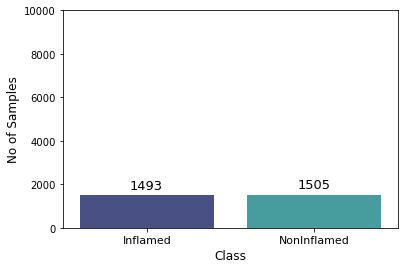

In [29]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("No of Samples", fontsize= 12)
plt.ylim(0,10000)
plt.xticks([0,1], ['Inflamed', 'NonInflamed'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

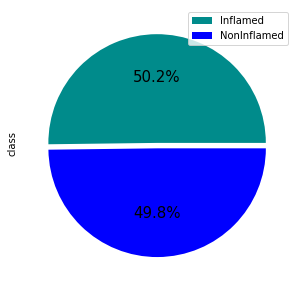

In [30]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Inflamed', 'NonInflamed'])
plt.show()

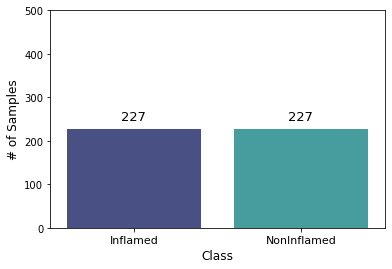

In [31]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Inflamed', 'NonInflamed'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

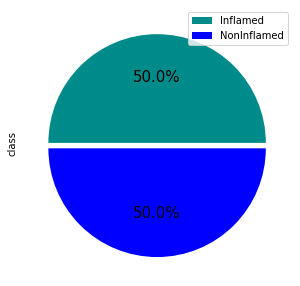

In [32]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Inflamed', 'NonInflamed'])
plt.show()

Train Set - Inflamed


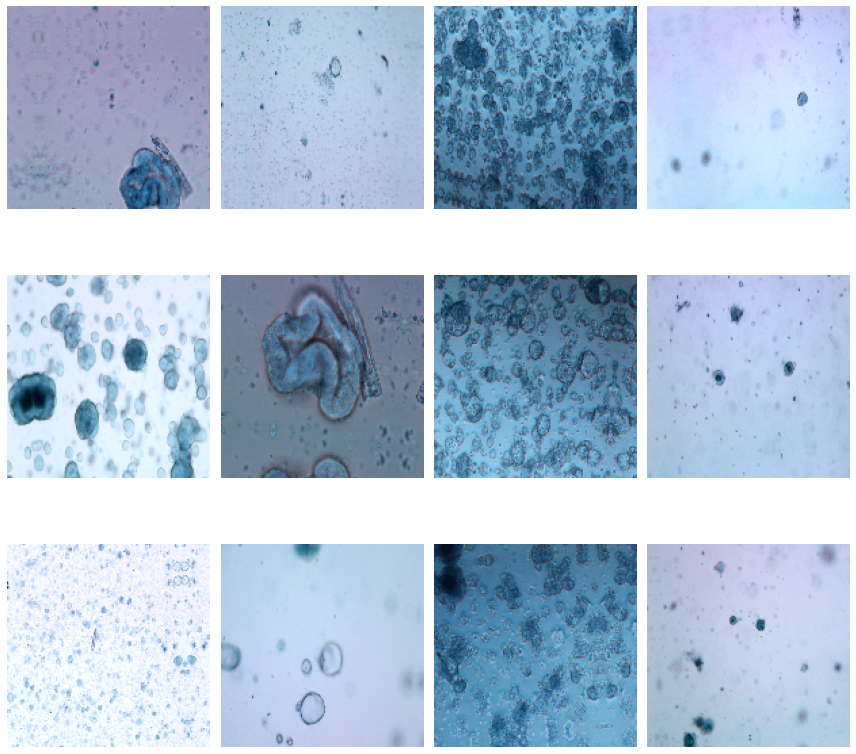

In [33]:
print('Train Set - Inflamed')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_i[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Train Set - NonInflamed


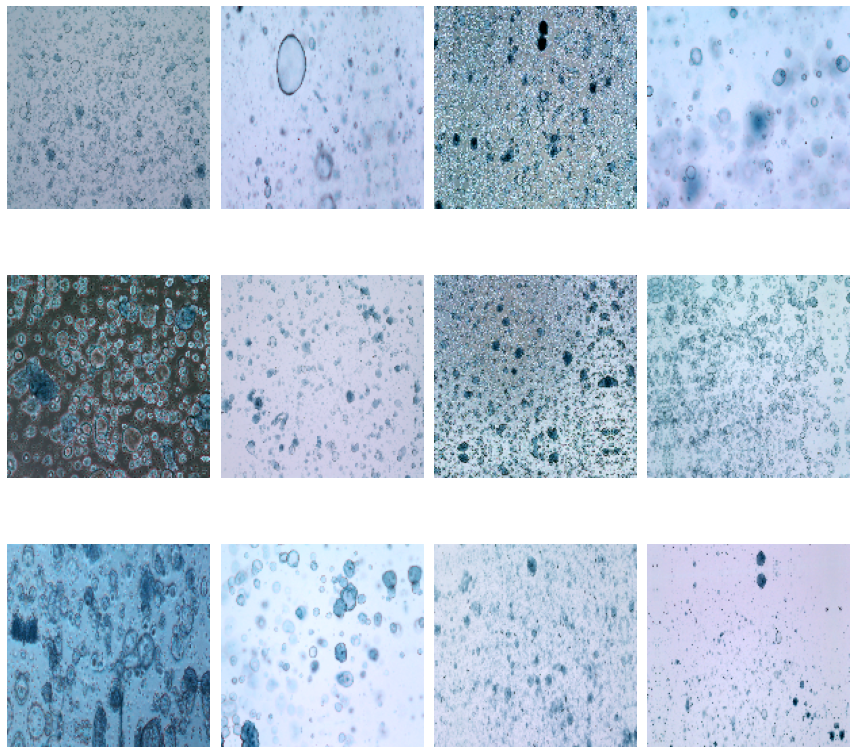

In [34]:
print('Train Set - NonInflamed')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_ni[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

In [35]:
# train_datagen = ImageDataGenerator(rescale=1/255.)
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range=10, # rotation
#         width_shift_range=0.2, # horizontal shift
#         height_shift_range=0.2, # vertical shift
#         zoom_range=0.2, # zoom
#         horizontal_flip=True, # horizontal flip
#         vertical_flip= True,
#         fill_mode = 'reflect',
#         brightness_range=[0.2,1.2])

# train_datagen = ImageDataGenerator(rescale=1./255)

# valid_datagen = ImageDataGenerator(rescale=1./255)

# test_datagen = ImageDataGenerator(rescale = 1./255)

# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('./dataset/new_aug_dataset/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')                                  

Found 2998 images belonging to 2 classes.


In [37]:
# Preprocessing the valid set
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_set = valid_datagen.flow_from_directory('./dataset/new_aug_dataset/val',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 841 images belonging to 2 classes.


In [49]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('./dataset/new_aug_dataset/test',
                                            target_size = (64, 64),
                                            batch_size = 1,
                                            class_mode = 'binary'

                                            )

Found 454 images belonging to 2 classes.


In [38]:
checkpoint_path = "./checkpoint_path/training_CNN_SVM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [39]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [40]:
checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint_path/training_CNN_SVM/model{epoch:08d}.h5',save_freq='epoch', period=10) 

In [41]:
# Part 2 - Building the CNN
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
#cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
## For Binary Classification
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [42]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [43]:
# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
r=cnn.fit(x = training_set, validation_data = valid_set, epochs = 100, callbacks=[cp_callback, checkpoint])

Epoch 1/100


2022-09-21 21:33:01.321117: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-21 21:33:01.883611: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


94/94 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.5130
Epoch 00001: saving model to ./checkpoint_path/training_CNN_SVM/cp.ckpt
94/94 [==============================] - 70s 750ms/step - loss: 1.0000 - accuracy: 0.5130 - val_loss: 1.0388 - val_accuracy: 0.4994
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: 0.9697 - accuracy: 0.5087
Epoch 00002: saving model to ./checkpoint_path/training_CNN_SVM/cp.ckpt
94/94 [==============================] - 69s 730ms/step - loss: 0.9697 - accuracy: 0.5087 - val_loss: 0.9114 - val_accuracy: 0.6231
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: 0.8432 - accuracy: 0.5907
Epoch 00003: saving model to ./checkpoint_path/training_CNN_SVM/cp.ckpt
94/94 [==============================] - 66s 697ms/step - loss: 0.8432 - accuracy: 0.5907 - val_loss: 0.8308 - val_accuracy: 0.7158
Epoch 4/100
94/94 [==============================] - ETA: 0s - loss: 0.8584 - accuracy: 0.5871
Epoch 00004: saving 

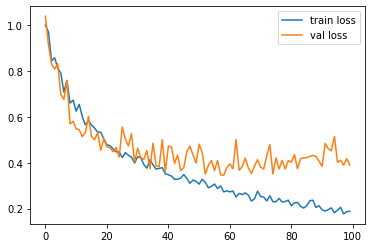

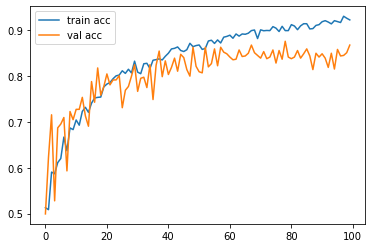

<Figure size 432x288 with 0 Axes>

In [44]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [50]:
cnn.evaluate(test_set)

454/454 [==============================] - 10s 23ms/step - loss: 1.1081 - accuracy: 0.7137


[1.1080766916275024, 0.7136563658714294]

In [1]:
from tensorflow.keras.models import load_model
train_model_2 = load_model('./checkpoint_path/training_2/model00000200.h5')

2022-09-24 13:23:03.080559: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-24 13:23:04.445581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-24 13:23:04.446418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-24 13:23:04.447239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2

In [4]:
train_dir = os.path.join("./dataset/new_aug_dataset/train/")
valid_dir = os.path.join('./dataset/new_aug_dataset/val/')
test_dir = os.path.join('./dataset/new_aug_dataset/test/')

train_i_dir = os.path.join('./dataset/new_aug_dataset/train/Inflamed/')
train_ni_dir = os.path.join('./dataset/new_aug_dataset/train/NonInflamed/')

valid_i_dir = os.path.join('./dataset/new_aug_dataset/val/Inflamed/')
valid_ni_dir = os.path.join('./dataset/new_aug_dataset/val/NonInflamed')

test_i_dir = os.path.join('./dataset/new_aug_dataset/test/Inflamed/')
test_ni_dir = os.path.join('./dataset/new_aug_dataset/test/NonInflamed')

In [5]:
train_i_names = os.listdir(train_i_dir)
print(train_i_names [:10])

train_ni_names  = os.listdir(train_ni_dir)
print(train_ni_names [:10])

valid_i_names = os.listdir(valid_i_dir)
print(valid_i_names[:10])

valid_ni_names = os.listdir(valid_ni_dir)
print(valid_ni_names[:10])

test_i_names = os.listdir(test_i_dir)
print(test_i_names[:10])

test_ni_names = os.listdir(test_ni_dir)
print(test_ni_names[:10])

['CD11 IL-I-QS_2496 20x 190603_0_8109.tif', 'CD11-Il-I_QS_2470_0_8255.tif', 'CD62-I-I P3 200311 4X_0_6247.tif', 'CD13-Il-I_QS_2479_0_7970.tif', 'CD41-I-I p3 10x 9-19-19_0_3677.tif', 'CD11 IL-I-QS_2501 40x 190603_0_3807.tif', 'CD63-I-I P4 200325 4X_0_2796.tif', 'CD13-Il-I_QS_2477_0_1462.tif', 'CD42-I-I P0 190905 4x _0_1927.tif', 'CD11 ILEUM I _0_9593.tif']
['CD11-LC-NI P12 190905 4x.tif', 'CD28-R-NI P0 190701 10x_0_5876.tif', 'CD47-I-NI P5 191115 4X_0_7696.tif', 'CD28-R-NI P2 190707 10X_0_7199.tif', 'CD47-LC-NI P3 191023 10X_0_7837.tif', 'CD24-I-NI P1 190620 4X.tif', 'CD50-I-NI P3 191212 4X_0_862.tif', 'CD20-I-NI P7 190729 4x_0_8158.tif', 'CD60-LC p2 5x 012720_0_9664.tif', 'CD30-I-NI P3 190805 10X_0_8651.tif']
['CD11 IL-I-QS_2497 20x 190603_0_3336.tif', 'CD11 IL-I-QS_2497 20x 190603_0_9838.tif', 'CD63-I-I P3 200318 4X_0_2713.tif', 'CD11 IL-I-QS_2500 40x 190603_0_7359.tif', 'CD11 IL-I-QS_2497 20x 190603_0_3398.tif', 'CD62-I-I P1 202026 10X_0_6212.tif', 'CD42-I-I P2 190920 4X_0_3345.tif',

In [6]:
print('total training i images:', len(os.listdir(train_i_dir)))
print('total training ni images:', len(os.listdir(train_ni_dir)))
print('total validation i images:', len(os.listdir(valid_i_dir)))
print('total validation ni images:', len(os.listdir(valid_ni_dir)))
print('total testing i images:', len(os.listdir(test_i_dir)))
print('total testing ni images:', len(os.listdir(test_ni_dir)))

num_train_i =  len(os.listdir(train_i_dir))
num_train_ni =  len(os.listdir(train_ni_dir))
num_val_i =  len(os.listdir(valid_i_dir))
num_val_ni =  len(os.listdir(valid_ni_dir))
num_test_i =  len(os.listdir(test_i_dir))
num_test_ni =  len(os.listdir(test_ni_dir))

total_train =num_train_i  + num_train_ni
total_val = num_val_i  + num_val_ni
total_test = num_test_i   + num_test_ni 

print("-----------------------------------------------------")
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total testing images:", total_test)

total training i images: 1493
total training ni images: 1505
total validation i images: 420
total validation ni images: 422
total testing i images: 227
total testing ni images: 228
-----------------------------------------------------
Total training images: 2998
Total validation images: 842
Total testing images: 455


In [7]:
train_i = glob.glob(train_i_dir+"/*.*")
train_ni = glob.glob(train_ni_dir+"/*.*")

In [8]:
valid_i = glob.glob(valid_i_dir+"/*.*")
valid_ni = glob.glob(valid_ni_dir+"/*.*")
# train_i_names

In [9]:
test_i = glob.glob(test_i_dir+"/*.*")
test_ni = glob.glob(test_ni_dir+"/*.*")
# train_i_names

In [10]:
train_list = [x for x in train_i]
train_list.extend([x for x in train_ni])

df_train = pd.DataFrame(np.concatenate([['Inflamed']*len(train_i) , ['NonInflamed']*len(train_ni)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

In [11]:
valid_list = [x for x in valid_i]
valid_list.extend([x for x in valid_ni])

df_valid = pd.DataFrame(np.concatenate([['Inflamed']*len(valid_i) , ['NonInflamed']*len(valid_ni)]), columns = ['class'])
df_valid['image'] = [x for x in valid_list]

In [12]:
test_list = [x for x in test_i]
test_list.extend([x for x in test_ni])

df_test = pd.DataFrame(np.concatenate([['Inflamed']*len(test_i) , ['NonInflamed']*len(test_ni)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [13]:
df_train

,class,image
0,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11 IL-I-QS_2496 20x 190603_0_8109.tif
1,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_8255.tif
2,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD62-I-I P3 200311 4X_0_6247.tif
3,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD13-Il-I_QS_2479_0_7970.tif
4,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD41-I-I p3 10x 9-19-19_0_3677.tif
...,...,...
2993,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD20-LC-NI P7 190801 4X_0_9237.tif
2994,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD63-LC-NI P5 200323 10X_0_4659.tif
2995,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R p3 9.14.19 10x_0_4453.tif
2996,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R-NI P6 191003 10X 3_0_5781.tif


In [14]:
class_i = df_train[df_train['class'] == 'Inflamed']
class_ni = df_train[df_train['class'] == 'NonInflamed']

In [15]:
class_i

,class,image
0,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11 IL-I-QS_2496 20x 190603_0_8109.tif
1,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_8255.tif
2,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD62-I-I P3 200311 4X_0_6247.tif
3,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD13-Il-I_QS_2479_0_7970.tif
4,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD41-I-I p3 10x 9-19-19_0_3677.tif
...,...,...
1488,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD11-Il-I_QS_2470_0_9548.tif
1489,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD 11 ILEUM_0_6516.tif
1490,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD42-I-I P2 190920 10X_0_9741.tif
1491,Inflamed,./dataset/new_aug_dataset/train/Inflamed/CD 11 ILEUM_0_2267.tif


In [16]:
class_ni

,class,image
1493,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD11-LC-NI P12 190905 4x.tif
1494,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD28-R-NI P0 190701 10x_0_5876.tif
1495,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD47-I-NI P5 191115 4X_0_7696.tif
1496,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD28-R-NI P2 190707 10X_0_7199.tif
1497,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD47-LC-NI P3 191023 10X_0_7837.tif
...,...,...
2993,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD20-LC-NI P7 190801 4X_0_9237.tif
2994,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD63-LC-NI P5 200323 10X_0_4659.tif
2995,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R p3 9.14.19 10x_0_4453.tif
2996,NonInflamed,./dataset/new_aug_dataset/train/NonInflamed/CD42-R-NI P6 191003 10X 3_0_5781.tif


In [17]:
df_valid

,class,image
0,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_3336.tif
1,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_9838.tif
2,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD63-I-I P3 200318 4X_0_2713.tif
3,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2500 40x 190603_0_7359.tif
4,Inflamed,./dataset/new_aug_dataset/val/Inflamed/CD11 IL-I-QS_2497 20x 190603_0_3398.tif
...,...,...
836,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD51-R-NI P7 200116 10X_0_2108.tif
837,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD28-R-NI P1 190707 10x .tif
838,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD20-I-NI P9 190806 4X_0_682.tif
839,NonInflamed,./dataset/new_aug_dataset/val/NonInflamed/CD12 IL-NI-QS_2512 40x 190603_0_5275.tif


In [18]:
df_test

,class,image
0,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 IL-I-QS_2493 10x 190603_0_8757.tif
1,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 IL-I-QS_2499 20x 190603_0_8721.tif
2,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 ILEUM Inf 2_0_6037.tif
3,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11 ILEUM Inf 2_0_4410.tif
4,Inflamed,./dataset/new_aug_dataset/test/Inflamed/CD11-I-I P8 190719 4X_0_2160.tif
...,...,...
449,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD60-LC-NI P2 10x 200204_0_8079.tif
450,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD23-LC-NI P4 190805 10X_0_1991.tif
451,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD50-R-NI P0 191119 4X_0_5509.tif
452,NonInflamed,./dataset/new_aug_dataset/test/NonInflamed/CD62-R-NI P4 200313 10X_0_5159.tif


In [20]:
train_datagen_tl = ImageDataGenerator(
        rescale=1/255.,
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        vertical_flip= True,
        fill_mode = 'reflect',
        brightness_range=[0.2,1.2]) # brightness
val_datagen_tl = ImageDataGenerator(rescale=1/255.)
test_datagen_tl = ImageDataGenerator(rescale=1/255.)

In [21]:
ds_train = train_datagen_tl.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 classes={'NonInflamed': 0., 'Inflamed': 1.}
                                                 )

Found 2998 images belonging to 2 classes.


In [22]:
ds_valid = val_datagen_tl.flow_from_directory(valid_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True,
                                                 classes={'NonInflamed': 0., 'Inflamed': 1.}
                                                 )

Found 841 images belonging to 2 classes.


In [23]:
ds_test = test_datagen_tl.flow_from_directory(test_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=False,
                                                 classes={'NonInflamed': 0., 'Inflamed': 1.}
                                                 )

Found 454 images belonging to 2 classes.


In [24]:

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [23]:
checkpoint_path = "./checkpoint_path/training_cnn_transfer/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [24]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [28]:
checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint_path/training_cnn_transfer/model{epoch:08d}.h5',save_freq='epoch', period=10) 

In [25]:
# inception v3
height = 224
width = 224



tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=input_shape
)
base_model.trainable = False

model_inceptionv3 = tf.keras.Sequential()
model_inceptionv3.add(base_model)
model_inceptionv3.add(tf.keras.layers.Flatten())
model_inceptionv3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_inceptionv3.compile(
                    loss='binary_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=['acc']
)
model_inceptionv3.summary()

2022-09-22 01:33:45.785782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-22 01:33:45.786887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-22 01:33:45.787956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-09-22 01:33:45.789001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 3 with properties: 
pciBusID: 0000:82:00.0 n

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51201     
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [26]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoint_path/training_cnn_transfer/inceptionv3_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model_inceptionv3.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=25, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/25


2022-09-22 01:34:13.019354: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-22 01:34:13.980954: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


94/94 [==============================] - ETA: 0s - loss: 0.8016 - acc: 0.7635
Epoch 00001: acc improved from -inf to 0.76351, saving model to ./checkpoint_path/training_cnn_transfer/inceptionv3_best.h5
94/94 [==============================] - 102s 1s/step - loss: 0.8016 - acc: 0.7635 - val_loss: 0.8111 - val_acc: 0.7206
Epoch 2/25
94/94 [==============================] - ETA: 0s - loss: 0.4356 - acc: 0.8426
Epoch 00002: acc improved from 0.76351 to 0.84256, saving model to ./checkpoint_path/training_cnn_transfer/inceptionv3_best.h5
94/94 [==============================] - 95s 1s/step - loss: 0.4356 - acc: 0.8426 - val_loss: 1.6694 - val_acc: 0.7360
Epoch 3/25
94/94 [==============================] - ETA: 0s - loss: 0.3970 - acc: 0.8706
Epoch 00003: acc improved from 0.84256 to 0.87058, saving model to ./checkpoint_path/training_cnn_transfer/inceptionv3_best.h5
94/94 [==============================] - 96s 1s/step - loss: 0.3970 - acc: 0.8706 - val_loss: 1.3707 - val_acc: 0.7087
Epoch 4/

KeyboardInterrupt: 

In [29]:
# history = model_pretrained.fit(ds_train,
#           batch_size = 32, epochs = 50,
#           validation_data=ds_valid,
#           callbacks=[cp_callback, checkpoint],
#           steps_per_epoch=(len(df_train)/32),
#           validation_steps=(len(df_valid)/32));

Epoch 1/50


2022-09-22 01:13:38.446280: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-22 01:13:39.109474: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


94/93 [==============================] - ETA: 0s - loss: 0.6048 - binary_accuracy: 0.7252
Epoch 00001: saving model to ./checkpoint_path/training_cnn_transfer/cp.ckpt
94/93 [==============================] - 75s 799ms/step - loss: 0.6048 - binary_accuracy: 0.7252 - val_loss: 0.5514 - val_binary_accuracy: 0.7515
Epoch 2/50
94/93 [==============================] - ETA: 0s - loss: 0.3559 - binary_accuracy: 0.8339
Epoch 00002: saving model to ./checkpoint_path/training_cnn_transfer/cp.ckpt
94/93 [==============================] - 67s 709ms/step - loss: 0.3559 - binary_accuracy: 0.8339 - val_loss: 0.5991 - val_binary_accuracy: 0.7634
Epoch 3/50
94/93 [==============================] - ETA: 0s - loss: 0.2605 - binary_accuracy: 0.8819
Epoch 00003: saving model to ./checkpoint_path/training_cnn_transfer/cp.ckpt
94/93 [==============================] - 70s 746ms/step - loss: 0.2605 - binary_accuracy: 0.8819 - val_loss: 0.5461 - val_binary_accuracy: 0.7765
Epoch 4/50
94/93 [=====================

KeyboardInterrupt: 

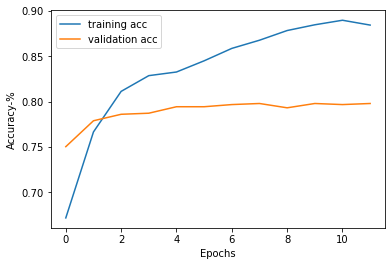

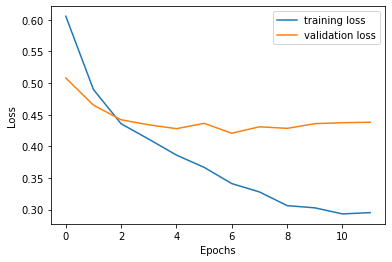

In [78]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['binary_accuracy']
    val_acc = history.history['val_binary_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plot_learning_curve(history)

In [79]:
model_pretrained.evaluate(ds_test) #validation#

15/15 [==============================] - 38s 3s/step - loss: 0.5669 - binary_accuracy: 0.7093


[0.5668585896492004, 0.7092511057853699]